In [6]:
from pathlib import Path
from bitcoin_risk.risk import prepare_and_compute_risk
from bitcoin_risk.plotter import create_figures
import pandas as pd

# complete data-range
start = pd.to_datetime('2010-01-04')
end = pd.to_datetime('2025-07-20')
future = pd.to_datetime('2035-01-31')

last_date = '2025-01-31'
# last_dates = ['2012-11-30', '2014-11-30', '2016-11-30','2018-11-30', '2020-11-30', '2022-11-30', '2024-11-30']
last_dates = ['2012-11-30', '2014-11-30', '2016-11-30','2018-11-30', '2020-11-30', '2022-11-30', '2024-11-30']
# last_dates = ['2025-07-20']

for last_date in last_dates:
   # result directory
   current_dir = Path.cwd()
   path = current_dir / "docs" / "btc" / last_date
   if not path.exists():
       path.mkdir(parents=True) 

   print(last_date)
   btc = prepare_and_compute_risk('data/BTCUSD_active.csv', start, end, future, last_date)
   fig1, fig2, fig3, fig4 = create_figures(btc, path)
   fig1.write_image('docs/fig/btc.png')
   fig2.write_image('docs/fig/risk.png')
   fig3.write_image('docs/fig/btc_time.png')
   fig4.write_image('docs/fig/time_risk.png')

2012-11-30
2014-11-30
2016-11-30
2018-11-30
2020-11-30
2022-11-30
2024-11-30


In [2]:
# display here
import pandas as pd
from bitcoin_risk.risk import prepare_and_compute_risk
from bitcoin_risk.plotter import create_figures
from pathlib import Path
start = pd.to_datetime('2010-01-04')
end = pd.to_datetime('2025-07-20')
future = pd.to_datetime('2035-01-30')

last_date = '2024-11-30'

# result directory
current_dir = Path.cwd()
path = current_dir / "tmp"
if not path.exists():
    path.mkdir(parents=True) 

# btc = pd.read_csv('data/BTCUSD_active.csv')
# btc = canonical_columns(btc)
# btc = extend_dates(btc, start, end, future)
# btc = log_fits(btc, last_included_date=last_date)
# print(btc)
btc = prepare_and_compute_risk('data/BTCUSD_active.csv', start, end, future, last_date)
fig1, fig2, fig3, fig4 = create_figures(btc, path)
fig1.show(); fig2.show(); fig3.show(); fig4.show()

/Users/romanellerbrock/miniconda3/envs/bitcoin_risk/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log

/var/folders/01/c_1q1nmd6xj9htpk8cfsr_vc0000gn/T/ipykernel_91377/2259969561.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





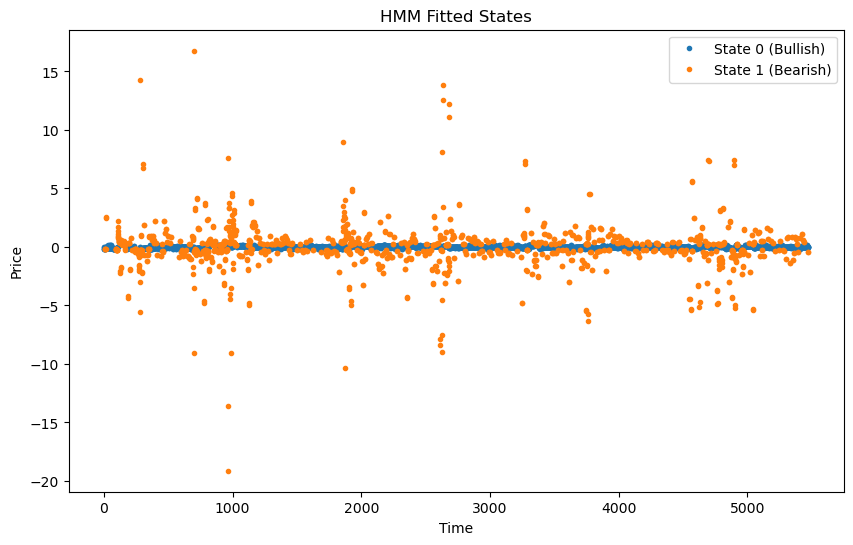

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

df = btc[btc['date'] <= pd.to_datetime('2024-12-30')].copy()
df['drisk'] = df['risk']
# df['drisk'] = df['risk'].pct_change(fill_method='bfill')

df['drisk'] = np.log(df['risk'] / df['risk'].shift(2))
df['drisk'].fillna(1e-3, inplace=True)

scaler = StandardScaler()
df['drisk'] = scaler.fit_transform(df[['drisk']])

values = df['drisk'].values.reshape(-1, 1)
plot_values = df['drisk']

# Fit a 2-state Hidden Markov Model
model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=100, random_state=42)
model.fit(values)

# Predict hidden states
hidden_states = model.predict(values)

# Add states to the DataFrame
df['state'] = hidden_states

# Plot the time series with the states
plt.figure(figsize=(10, 6))
for state in range(model.n_components):
    state_mask = hidden_states == state
    plt.plot(df.index[state_mask], plot_values[state_mask], '.', label=f"State {state} ({'Bullish' if state == 0 else 'Bearish'})")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('HMM Fitted States')
plt.show()


State 0: Mean = [0.22654563 0.17553716 0.52953322 1.         0.23067208], Variance = [2.99203407e-02 7.32037910e-02 1.26789350e-01 1.69803559e-05
 3.90232505e-02]
State 1: Mean = [1.39857033e-02 4.29236324e-03 1.71158194e+02 4.66666667e-01
 1.75372968e-01], Variance = [3.07856399e-03 3.82609901e-04 7.91606947e-04 7.82555556e-01
 5.20080287e-03]
State 2: Mean = [-4.62844015e-02 -2.02264424e-03  4.74601047e+00 -5.07097236e-01
 -2.14531507e-02], Variance = [1.58837315e-02 3.83630388e-03 4.67565963e+01 6.89587283e-01
 3.13924455e-02]
State 3: Mean = [-0.10262978  0.34478903  0.06958923 -1.         -0.09459834], Variance = [6.79763532e-03 1.30726267e-01 5.76442635e-03 3.85843038e-06
 3.21346859e-02]
State 4: Mean = [0.09380251 0.29643409 0.08379441 1.         0.07063133], Variance = [5.80261314e-03 1.33588599e-01 2.41704631e-03 5.87777519e-06
 1.92806841e-02]


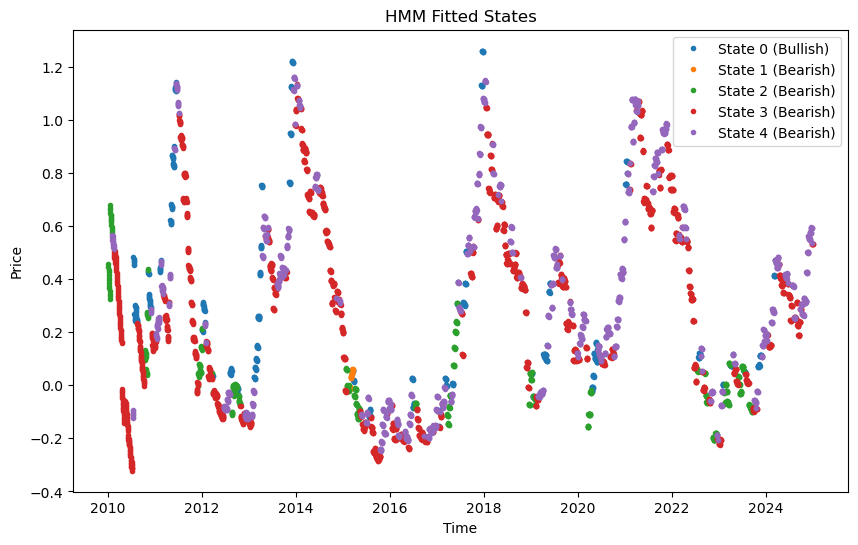

In [88]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import linregress

def compute_slope(series, window=10):
    slopes = series.rolling(window).apply(lambda x: linregress(range(len(x)), x)[0], raw=False)
    return slopes

n_comp = 5
rolling_window = 10

df = btc[btc['date'] <= pd.to_datetime('2024-12-30')].copy()
# df['1'] = (df['risk'] - df['risk'].shift(rolling_window))

# df['up'] = np.where(df['1'] > 0, df['1'], 0)
# df['down'] = np.where(df['1'] < 0, df['1'], 0)
# df['2'] = df['up'].rolling(window=rolling_window).std()
# df['3'] = df['down'].rolling(window=rolling_window).std()
# df['4'] = df['risk']

# df['1'] = df['risk'] - df['risk'].shift(10)  # Difference over a 10-period window
# df['2'] = df['risk'].rolling(window=10).mean()  # Rolling mean over 10 periods
# df['3'] = df['risk'].pct_change().rolling(window=10).std()

# Create columns
window = 30
df['momentum'] = df['risk'] - df['risk'].shift(window)
df['rolling_mean'] = df['risk'].rolling(window=window).mean()
df['volatility'] = df['risk'].pct_change().rolling(window=window).std()
# df['trend_slope'] = compute_slope(df['risk'], window=10)
df['direction'] = np.where(df['momentum'] > 0, 1, np.where(df['momentum'] < 0, -1, 0))
df['acceleration'] = df['momentum'] - df['momentum'].shift(window)

dfdf = df.iloc[100:-100]
df.fillna(0, inplace=True)


X = df[['momentum', 'rolling_mean', 'volatility', 'direction', 'acceleration']].values


# old window data
# df['2'] = np.log(df['risk'] / df['risk'].shift(15))
# df['3'] = df['2'].rolling(window=30).std()
# df['2'] = df['risk']
# df['3'] = df['risk'] - df['risk'].shift(3)

# Scale data
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

values = df[['risk']].values

# Fit HMM
model = GaussianHMM(n_components=n_comp, covariance_type="diag", n_iter=100)
model.fit(X)

# Predict states
hidden_states = model.predict(X)
df['state'] = hidden_states

# Inspect model parameters
for i in range(model.n_components):
    print(f"State {i}: Mean = {model.means_[i]}, Variance = {np.diag(model.covars_[i])}")

plt.figure(figsize=(10, 6))
for state in range(model.n_components):
    state_mask = hidden_states == state
    plt.plot(df['date'][state_mask], values[state_mask], '.', label=f"State {state} ({'Bullish' if state == 0 else 'Bearish'})")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('HMM Fitted States')
plt.show()


In [4]:
for state in range(model.n_components):
    mask = (hidden_states == state)
    print(f"State {state} - Mean: {df[mask].mean()}, Std: {df[mask].std()}")


State 0 - Mean: date           2017-09-30 16:10:49.679569152
usd                             15326.145906
fit                             12532.481868
undervalued                      8185.095757
overvalued                      21185.834794
bubble                          29430.401543
top                             36210.026672
time-risk                           96.34966
risk                                0.345097
drisk                              -0.008077
state                                    0.0
dtype: object, Std: date           1560 days 06:51:27.014127792
usd                            21786.283163
fit                            17862.878607
undervalued                    11874.758792
overvalued                     29611.574629
bubble                         40224.999038
top                             48454.15358
time-risk                        409.809845
risk                               0.376461
drisk                              0.163363
state                        

date       usd            fit    undervalued    overvalued  \
0    2010-01-04  0.000718       0.000320       0.000117  9.997698e-04   
1    2010-01-05  0.000718       0.000333       0.000122  1.041792e-03   
2    2010-01-06  0.000718       0.000348       0.000128  1.085199e-03   
3    2010-01-07  0.000718       0.000363       0.000133  1.130025e-03   
4    2010-01-08  0.000718       0.000378       0.000139  1.176302e-03   
...         ...       ...            ...            ...           ...   
9092 2034-11-26       NaN  820895.670450  596339.293427  1.248139e+06   
9093 2034-11-27       NaN  821337.141289  596670.149366  1.248788e+06   
9094 2034-11-28       NaN  821778.801572  597001.152911  1.249437e+06   
9095 2034-11-29       NaN  822220.651358  597332.304113  1.250087e+06   
9096 2034-11-30       NaN  822662.690709  597663.603020  1.250737e+06   

            bubble           top  time-risk      risk        ddt  
0     2.736738e-03  6.239594e-03  20.572384  0.456395        NaN  
1     2.847275e-03  6.482295e-03  19.572384  0.445994        NaN  
2     2.961276e-03  6.732244e-03  18.572384  0.435653        NaN  
3     3.078820e-03  6.989594e-03  17.572384  0.425370        NaN  
4     3.199984e-03  7.254499e-03  16.572384  0.415143        NaN  
...            ...           ...        ...       ...        ...  
9092  1.532018e+06  1.682128e+06        NaN       NaN  22.170517  
9093  1.532784e+06  1.682938e+06        NaN       NaN  22.167806  
9094  1.533550e+06  1.683749e+06        NaN       NaN  22.165096  
9095  1.534317e+06  1.684560e+06        NaN       NaN  22.162386  
9096  1.535084e+06  1.685371e+06        NaN       NaN  22.159677  

[9097 rows x 10 columns]

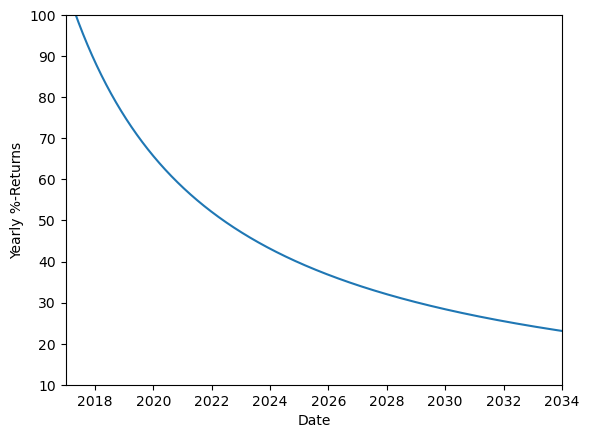

In [4]:
import pandas as pd
from pathlib import Path
from bitcoin_risk.risk import prepare_and_compute_risk
from bitcoin_risk.risk import _unix_to_btc_time, _bitcoin_time
import numpy as np

# complete data-range
start = pd.to_datetime('2010-01-04')
end = pd.to_datetime('2024-11-30')
future = pd.to_datetime('2034-11-30')
last_date = '2024-11-30'

# result directory
current_dir = Path.cwd()
path = current_dir / "docs" / "btc" / last_date
if not path.exists():
    path.mkdir(parents=True) 

btc = prepare_and_compute_risk('data/BTCUSD_2024_12_24.csv', start, end, future, last_date)

def _evaluate_fit(fit, date):
    # date -> btc-time
    x = pd.to_datetime(date)
    x = x.apply(lambda x: x.timestamp())
    x = _unix_to_btc_time(x)
    x = np.log(x)
    return fit[0] * np.exp(fit[0] * x + fit[1])


def btc_fit(btc, dates, price):
    """
    Performs a logscale linear fit on the Bitcoin price data to predict future prices.

    Parameters:
    - dates (pd.Series): A series of dates for which the Bitcoin prices are known.
    - price (pd.Series): A series of Bitcoin prices corresponding to the dates.

    Returns:
    - pd.Series: A series of predicted Bitcoin prices based on the logscale linear fit.
    """
    t = _bitcoin_time(dates)
    t = np.log(t)
    y = np.log(price)
    btc_fit = np.polyfit(t, y, 1)
    return _evaluate_fit(btc_fit, btc['date'])


btc['ddt'] = ((btc['fit'] / btc['fit'].shift(365)) - 1) * 100.
display(btc)

import matplotlib.pyplot as plt
plt.plot(btc['date'], btc['ddt'])
# plt.yscale('log')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2034-01-01'))
plt.ylim((1e1, 1e2))
plt.xlabel("Date")
plt.ylabel("Yearly %-Returns")
plt.show()